# Data Cleaning 

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np


In [2]:
# Functions for data cleaning

#  Functions for Duplicate checks 
def get_exact_dups(df):
    '''
    Returns duplicates
    '''
    dups = df[df.duplicated()]
    return dups

def get_tweet_text_dups(df, col_names):
    '''
    Returns duplicates based on given column name
    '''
    dups = df[df.duplicated(subset=col_names)]
    return dups



In [3]:
raw_data = pd.read_csv('../data/crowdflower-brands-and-product-emotions/data/judge_1377884607_tweet_product_company.csv')

raw_data.shape

(8721, 3)

In [4]:
raw_data.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


## Original Data Column Descriptions

* tweet_text - Text/content of the Tweet
* emotion_in_tweet_is_directed_at - Brand/Product Category (Apple Product or Google Product)
* is_there_an_emotion_directed_at_a_brand_or_product - Human labeled emotion/sentiment of the Tweet text, Positive/Negative/Neutral


### Make a deep copy of the original data and rename the columns for readablilty/ease of typing

## Renamed Data columns
* tweet_text 
* brand_or_product
* emotion

In [5]:
# Make a deep copy before any data cleaning (Deep copy has own copy of data and index)
processed_data = raw_data.copy(deep=True)

In [6]:
# Rename those verbose columns!
processed_data.rename(columns={'emotion_in_tweet_is_directed_at': 'labeled_brand_or_product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'detected_emotion'}, inplace=True)
processed_data.head(1)

,tweet_text,labeled_brand_or_product,detected_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


## Data cleaning steps:
* __Duplicate check/ Duplicate handling__ 

* __Null check/Null handling__

* __Data type conversion__

In [7]:
# Duplicate check and handling

# We do have EXACT duplicates?
exact_dups = get_exact_dups(processed_data)
print(len(exact_dups))

# Drop 'em
processed_data.drop_duplicates(inplace=True)

22


In [8]:
# Do we have duplicated tweet texts?
tweet_dups = get_tweet_text_dups(processed_data, ['tweet_text'])
print(len(tweet_dups))

# Yes!  What is going on here?
display(tweet_dups)

print(tweet_dups['tweet_text'].unique())

5


,tweet_text,labeled_brand_or_product,detected_emotion
3628,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3629,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
6063,RT @mention Marissa Mayer: Google Will Connect...,NaN,No emotion toward brand or product
6064,RT @mention Marissa Mayer: Google Will Connect...,NaN,No emotion toward brand or product
6345,RT @mention RT @mention It's not a rumor: Appl...,NaN,No emotion toward brand or product


['Win free ipad 2 from webdoc.com #sxsw RT'
 'Win free iPad 2 from webdoc.com #sxsw RT'
 'RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw'
 'RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW'
 "RT @mention RT @mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}"]


In [9]:
'''
It looks like pandas is doing something interesting with checking for duplicate text values.

3628 and 3629 have ALL the same words but a small difference in case (ipad vs iPad)
6063, 6064 have ALL the same words but a small difference in case (#sxsw vs #SXSW)
6345 - Not sure why this was returned as a duplicate. Will keep it. 

Overall- there are very few duplicated tweets.  Just keep them all.
'''


'\nIt looks like pandas is doing something interesting with checking for duplicate text values.\n\n3628 and 3629 have ALL the same words but a small difference in case (ipad vs iPad)\n6063, 6064 have ALL the same words but a small difference in case (#sxsw vs #SXSW)\n6345 - Not sure why this was returned as a duplicate. Will keep it. \n\nOverall- there are very few duplicated tweets.  Just keep them all.\n'

In [10]:
# Null checks

# What percentage of data is null?
display(processed_data.isnull().mean())

tweet_text                  0.000115
labeled_brand_or_product    0.636740
detected_emotion            0.000000
dtype: float64

We have some null tweet_text values.  Drop these rows as we have to have text to classify.


In [11]:
processed_data.dropna(subset=['tweet_text'],inplace=True)

~64% of the brand_or_product data is null.  What to do? 

My text classifier will only be interested in postitive or negative sentiment on a product.

Don't drop any rows. Fill the null with UNKNOWN for now.

In [12]:
processed_data['labeled_brand_or_product'].fillna('UNKNOWN', inplace=True)
display(processed_data.isnull().mean())

tweet_text                  0.0
labeled_brand_or_product    0.0
detected_emotion            0.0
dtype: float64

In [13]:
# Data type conversion - make sure that tweet text is a string.... ran in issue with finding  a float value
processed_data['tweet_text'] = processed_data['tweet_text'].astype(str)

### New Column Creation
* sentiment - Positive/Negative/Neutral based off of __detected_emotion__ column values.
* brand - Apple/Google/UNKNOWN based off of __brand_or_product__column values.
* tweet_char_count - Total number of character count in Tweet

In [14]:
# Create new cols based of existing values. What are the unique values we have to work with?
print(processed_data['detected_emotion'].unique())
print(processed_data['labeled_brand_or_product'].unique())


['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
['iPhone' 'iPad or iPhone App' 'iPad' 'Google' 'UNKNOWN' 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']


In [15]:
# New column creation functions

def get_sentiment(detected_emotion_str):
    '''
    Get simple sentiment label
    '''
    sentiment = 'Neutral'
    if detected_emotion_str == 'Positive emotion':
        sentiment = 'Positive'
    elif detected_emotion_str == 'Negative emotion':
        sentiment = 'Negative'
    return sentiment

def get_brand(labeled_brand_or_product_str, tweet_text_str):
    '''
    Get simple brand name
    '''
    brand = 'UNKNOWN'
    if ((labeled_brand_or_product_str.lower().__contains__('google')) or (labeled_brand_or_product_str.lower().__contains__('android'))):
        brand = 'Google'
    elif ((labeled_brand_or_product_str.lower().__contains__('apple')) or (labeled_brand_or_product_str.lower().__contains__('ip'))):
        brand = 'Apple'

    # next level of trying detect brand if it was not labeled in the original data
    # if both brand identifiers are in the tweet text...the first match (google) will be brand
    if (brand == 'UNKNOWN'):
        tweet_lc = tweet_text_str.lower()
        has_google_identifiers = (tweet_lc.__contains__('google')) or (tweet_lc.lower().__contains__('android'))
        has_apple_identifers = (tweet_lc.__contains__('apple')) or (tweet_lc.__contains__('ip'))

        if (has_google_identifiers and has_apple_identifers):
            brand ='BOTH'
        elif (has_google_identifiers):
            brand = 'Google'
        elif (has_apple_identifers):
            brand = 'Apple'

    return brand

def get_tweet_char_count(tweet_text_str):
    ''' Get character count of the given tweet text'''
    return len(tweet_text_str.strip())

In [16]:
# Create the new sentiment column
processed_data['sentiment'] = processed_data.apply(lambda row: get_sentiment(row['detected_emotion']), axis=1)
processed_data.head(2)

,tweet_text,labeled_brand_or_product,detected_emotion,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive


In [17]:
# Create the new brand column
processed_data['brand'] = processed_data.apply(lambda row: get_brand(row['labeled_brand_or_product'], row['tweet_text']), axis=1)
processed_data.tail(2)

,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand
8719,Some Verizon iPhone customers complained their...,UNKNOWN,No emotion toward brand or product,Neutral,Apple
8720,�ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...,UNKNOWN,No emotion toward brand or product,Neutral,Google


In [18]:
processed_data['tweet_char_count'] = processed_data.apply(lambda row: get_tweet_char_count(row['tweet_text']), axis=1)
processed_data.head(2)

,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,Apple,127
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,Apple,139


In [19]:
# Save the processed data to files 
# ALL tweets
processed_data.to_csv('../data/cleaned_tweets_all.csv', index_label='id')
# Positive tweets
processed_data[processed_data['sentiment'] == 'Positive'].to_csv('../data/cleaned_tweets_positive.csv', index_label='id')
# Negative tweets
processed_data[processed_data['sentiment'] == 'Negative'].to_csv('../data/cleaned_tweets_negative.csv', index_label='id')
# Neutral tweets
processed_data[processed_data['sentiment'] == 'Neutral'].to_csv('../data/cleaned_tweets_neutral.csv', index_label='id')

# EDA and Stakeholder

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np

import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%matplotlib inline

In [2]:
# Function Definitions

def get_pretty_percent(x, y):
    ''' Get formatted percent '''
    percentage = round(x/y, 3)
    return str(percentage) + '% '


In [3]:
# read in the processed data
cleaned_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(cleaned_tweets.shape)
cleaned_tweets.head(3)

(8698, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,Apple,127
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,Apple,139
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive,Apple,79


## Question 1: What is the general sentiment breakdown for these Tweets?
### How many/what percentage Positive/Negative/Neutral?


In [112]:
by_sentiment = cleaned_tweets.groupby(['sentiment'])['tweet_text'].count()
by_sentiment.sort_values(ascending=False, inplace=True)

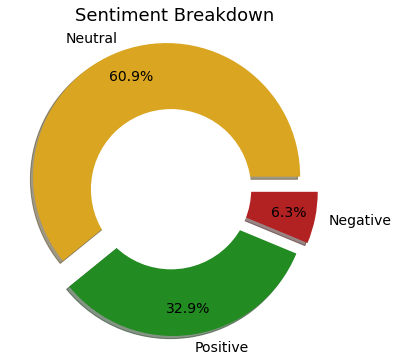

In [114]:
fig2, ax2 = plt.subplots(figsize=(6,6))

my_explode = (0.1, 0.1, 0.1)
my_colors = ['goldenrod','forestgreen', 'firebrick']
plt.pie(by_sentiment, labels=by_sentiment.index, autopct='%1.1f%%', shadow=True, 
        pctdistance=0.80, explode=my_explode, colors=my_colors)
plt.title('Sentiment Breakdown', size='18')

#draw circle and convert pie chart to Donut Chart
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.show()

In [88]:
by_sentiment_pos_neg = cleaned_tweets[cleaned_tweets['sentiment'] != 'Neutral'].groupby(['sentiment'])['tweet_text'].count()
by_sentiment_pos_neg.sort_values(ascending=False, inplace=True)

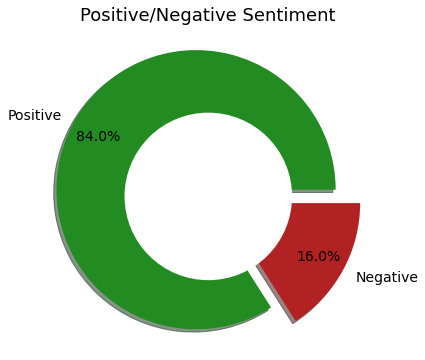

In [115]:
fig2, ax2 = plt.subplots(figsize=(6,6))

my_explode = (0.1, 0.1)
my_colors = ['forestgreen', 'firebrick']
plt.pie(by_sentiment_pos_neg, labels=by_sentiment_pos_neg.index, autopct='%1.1f%%', shadow=True, 
        pctdistance=0.80, explode=my_explode, colors=my_colors)
plt.title('Positive/Negative Sentiment', size='18')

#draw circle and convert pie chart to Donut Chart
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.show()

### Q1 Insights/Recommendations:
* Overall, the majority of the tweets are neutral. I am looking to create a binary classifier using only Positive/Negative sentiment. Be aware of too little training data.
* There is a __class imbalance__ issue here with more Positive than Negative labeled tweets. Be aware of this when training the classifier.


## Question 2: Are the two companies represented equally in the labeled data?

In [7]:
by_brand = cleaned_tweets.groupby('brand')['tweet_text'].count()
by_brand.sort_values(ascending=False, inplace=True)

In [8]:
by_brand

brand
Apple      5140
Google     2638
UNKNOWN     715
BOTH        205
Name: tweet_text, dtype: int64

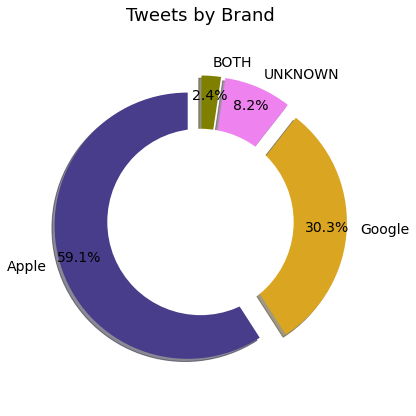

In [119]:
fig2, ax2 = plt.subplots(figsize=(6,6))

my_explode = (0.1, 0.1, 0.1, 0.1)
my_colors = ['darkslateblue', 'goldenrod', 'violet', 'olive']
plt.pie(by_brand, labels=by_brand.index, autopct='%1.1f%%', shadow=True, 
        startangle=90, pctdistance=0.85, explode=my_explode, colors=my_colors)
plt.title('Tweets by Brand', size='18')

#draw circle and convert pie chart to Donut Chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.show()

### Q2 Insights/Recommendations:
* Apple is the most mentioned brand, followed by Google, then Unknown. A small percentage of tweets mention both brands.
* It will be interesting to see how, it at all, brand name mentions factor into the classifier.

## Question 3: What insights can the data provide for specific Brands?
 We are ignoring the Tweets where brand is unknown.

In [10]:
brand_by_sentiment = cleaned_tweets[cleaned_tweets['brand'] != 'UNKNOWN'].groupby(['brand', 'sentiment'])['tweet_text'].count()
brand_by_sentiment

brand   sentiment
Apple   Negative      398
        Neutral      2694
        Positive     2048
BOTH    Negative        3
        Neutral       192
        Positive       10
Google  Negative      142
        Neutral      1706
        Positive      790
Name: tweet_text, dtype: int64

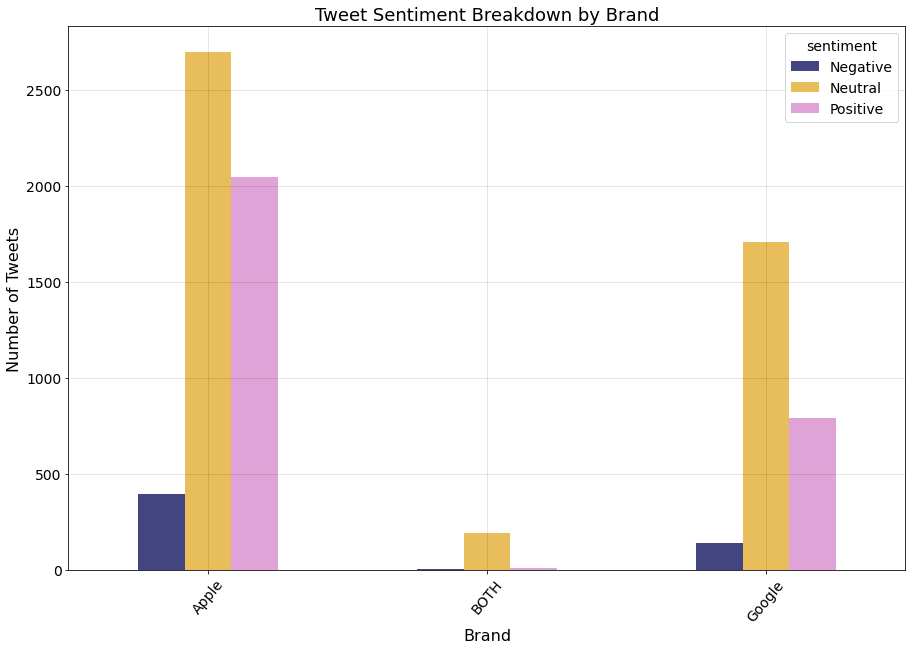

In [120]:
brand_by_sentiment.unstack().plot.bar(fontsize=14, rot=50, alpha=0.95, figsize=(15,10), colormap='tab20b')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.title('Tweet Sentiment Breakdown by Brand', size='18')
plt.xlabel('Brand',size=16)
plt.ylabel('Number of Tweets',size=16)
plt.yticks(size=14)
plt.show()

### Q3 Insights/Recommendations:
* Brand sentiment breakdown:
    * Both Apple and Google have many more Positive tweets than Negative
    * Both brands have many, many more Neutral tweets than Postive and Negative combined
    * How do the ratios of Negative to Positive tweets compare for Apple and Google?
        * 398:2018 Apple, 149:790 Google
        * 0.19 Apple, 0.18 Google
        * __Similar Ratios__

# Corpus EDA

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np

import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%matplotlib inline

from myFunctions import process_tweet_text_encode_to_ascii
from myFunctions import get_social_media_stopwords_list
from myFunctions import plot_word_cloud
from myFunctions import clean_tweet, tokenize_tweet, tokenize_lemmatize_tweet

In [2]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding = 'unicode_escape')
neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding = 'unicode_escape')
neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding = 'unicode_escape')
all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')

## Most Common Words
What are the most common words found in Positive, Negative and Neutral Tweets?

In [3]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets
# Note: no lemma done here
positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


In [4]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def plot_wordcloud(text, stopwords_list, bg_color='white', mask=None, max_words=400, max_font_size=120, figure_size=(10,10), 
                   title=None, title_size=40, title_color='green', image_color=False):
    ''' Plot a customized word cloud'''
    stopwords = set(stopwords_list)

    wordcloud = WordCloud(background_color=bg_color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    min_word_length=2,
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': title_color, 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
d = '../images/'

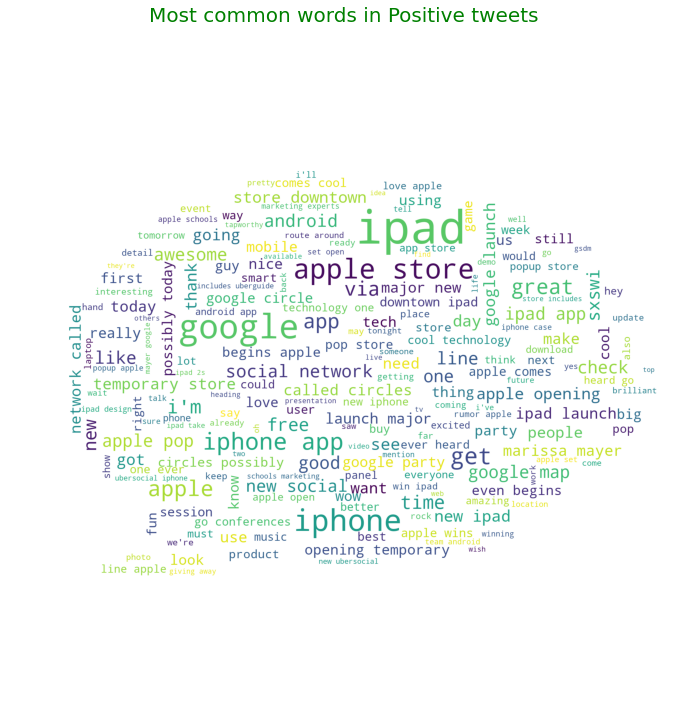

In [5]:
# Postive Tweets top words
pos_text = ' '.join(word for word in positive_tweet_words)
pos_mask = np.array(Image.open(d + 'comment.png'))
plot_wordcloud(pos_text, get_social_media_stopwords_list(), mask=pos_mask, max_words=200, max_font_size=140, 
               title = 'Most common words in Positive tweets', title_size=20)

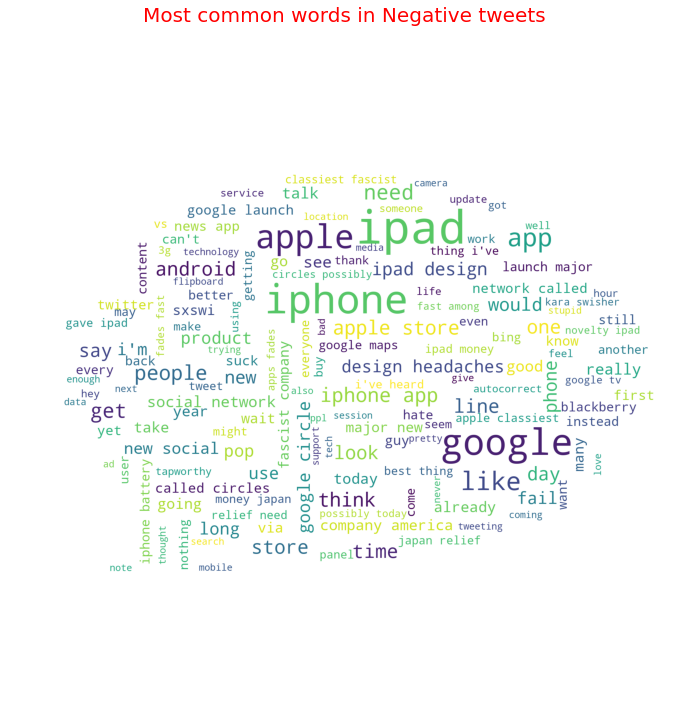

In [6]:
# Negative Tweets top words
neg_text = ' '.join(word for word in negative_tweet_words)
neg_mask = np.array(Image.open(d + 'comment.png'))
plot_wordcloud(neg_text, get_social_media_stopwords_list(), mask=neg_mask, max_words=150, max_font_size=140, 
               title = 'Most common words in Negative tweets', title_size=20, title_color='red')

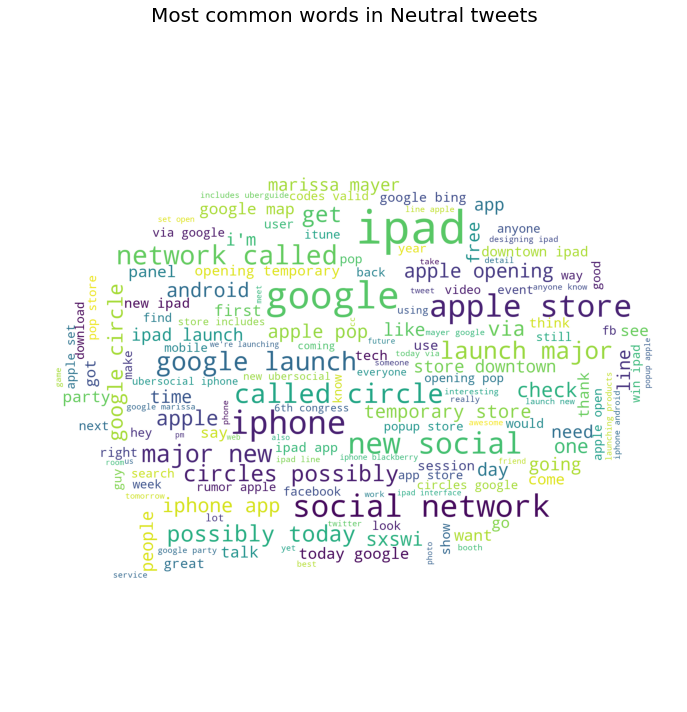

In [8]:
# Neutral Tweets top words
nu_text = ' '.join(word for word in neutral_tweet_words)
nu_mask = np.array(Image.open(d + 'comment.png'))
plot_wordcloud(nu_text, get_social_media_stopwords_list(), mask=nu_mask, max_words=150, max_font_size=140, 
               title = 'Most common words in Neutral tweets', title_size=20, title_color='black')

### Insights/Recommendations:
* This is really mainly for fun and to give a quick look at what consumers are saying. Word clouds are not suitable for doing any deep analysis of word frequencies. :)
* One thing to notice, there are words that appear in all three clouds. Consumers are using these words on all Tweets no matter the sentiment.

## Is there a difference in character count between Postitive/Negative/Neutral Tweets?
### Histogram of char count for each sentiment class

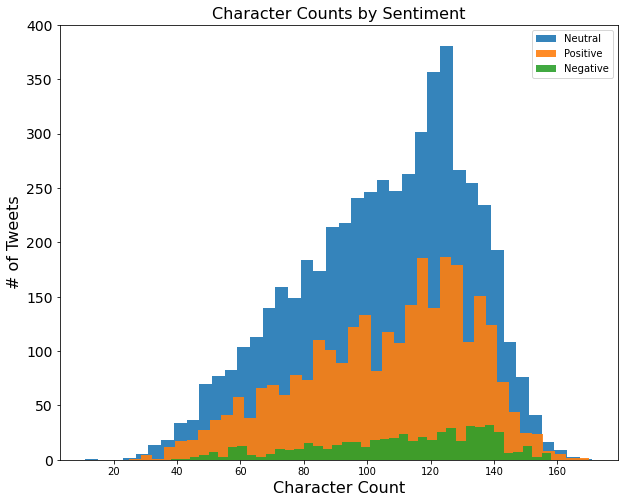

In [35]:
# Show the distribution of tweet character count for each of the sentiment classes
plfig = plt.figure(figsize = (10, 8))
plt.hist(neutral_tweets['tweet_char_count'], bins=40, alpha=0.9)
plt.hist(pos_tweets['tweet_char_count'], bins=40,alpha=0.9)
plt.hist(neg_tweets['tweet_char_count'], bins=40, alpha=0.9)
plt.legend(('Neutral', 'Positive', 'Negative'))
plt.grid=False
plt.xlabel('Character Count', size=16)
plt.ylabel('# of Tweets', size=16)
plt.title('Character Counts by Sentiment', size=16)
plt.yticks(size=14)
plt.show()

### Insights/Recommendations:
* Character Count won't be a good feature for Classification. There is overlap between all three Sentiment classes. 

## Future Work
* Explore if punctuation would be a good feature for text classification.